In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('crime.csv', encoding='latin-1', parse_dates=['OCCURRED_ON_DATE'])

In [3]:
day_of_week = {
    'Monday': 1,
    'Tuesday':2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

df['SHOOTING'].fillna(0, inplace = True)

df['SHOOTING'] = df['SHOOTING'].map({
    0: 0,
    'Y':1
})
df = df[df['Lat'] != -1].dropna()

## 1. How has crime changed over the years?

In [4]:
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182080058,2403,Disorderly Conduct,DISTURBING THE PEACE,E18,495,0,2018-10-03 20:13:00,2018,10,Wednesday,20,Part Two,ARLINGTON ST,42.262608,-71.121186,"(42.26260773, -71.12118637)"
1,I182080053,3201,Property Lost,PROPERTY - LOST,D14,795,0,2018-08-30 20:00:00,2018,8,Thursday,20,Part Three,ALLSTON ST,42.352111,-71.135311,"(42.35211146, -71.13531147)"
2,I182080052,2647,Other,THREATS TO DO BODILY HARM,B2,329,0,2018-10-03 19:20:00,2018,10,Wednesday,19,Part Two,DEVON ST,42.308126,-71.076930,"(42.30812619, -71.07692974)"
3,I182080051,413,Aggravated Assault,ASSAULT - AGGRAVATED - BATTERY,A1,92,0,2018-10-03 20:00:00,2018,10,Wednesday,20,Part One,CAMBRIDGE ST,42.359454,-71.059648,"(42.35945371, -71.05964817)"
4,I182080050,3122,Aircraft,AIRCRAFT INCIDENTS,A7,36,0,2018-10-03 20:49:00,2018,10,Wednesday,20,Part Three,PRESCOTT ST,42.375258,-71.024663,"(42.37525782, -71.02466343)"


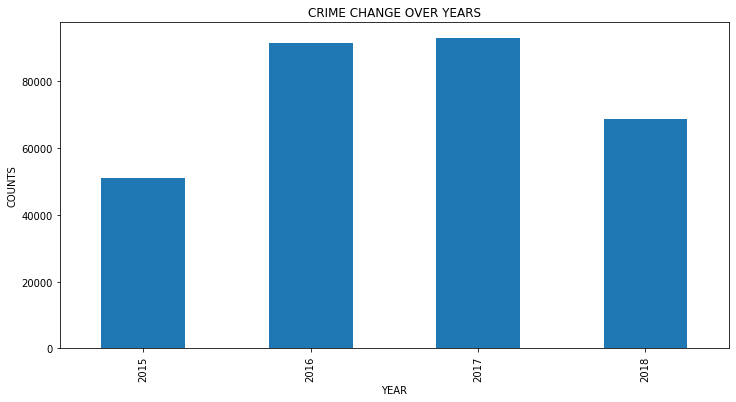

In [5]:
plt.figure(figsize=(12,6))
df['YEAR'].value_counts(sort=False).plot(kind='bar')
plt.xlabel('YEAR')
plt.ylabel('COUNTS')
plt.title('CRIME CHANGE OVER YEARS')
plt.show()

It can be seen how crimes change according to years in this plot.

## 2. Is it possible to predict where or when a crime will be committed?

In [6]:
# Select the features that we will use to predict.
df['Night'] = df['HOUR'].apply(lambda x: 0 if 6<=x<=18 else 1)
to_model = df['OFFENSE_CODE_GROUP'].value_counts()[:20].index
df_model = df[df['OFFENSE_CODE_GROUP'].isin(to_model)]

def to_map(x):
    dict_map = dict(zip(df_model[x].unique(), range(len(df_model[x].unique()))))
    return dict_map

df_model['OFFENSE_CODE_GROUP'] = df_model['OFFENSE_CODE_GROUP'].map(to_map('OFFENSE_CODE_GROUP'))
df_model['DISTRICT'] = df_model['DISTRICT'].map(to_map('DISTRICT'))
df_model['REPORTING_AREA'] = df_model['REPORTING_AREA'].map(to_map('REPORTING_AREA'))
df_model['DAY_OF_WEEK'] = df_model['DAY_OF_WEEK'].map(day_of_week)

X = df_model[['OFFENSE_CODE_GROUP', 'MONTH','DAY_OF_WEEK', 'HOUR', 'Night']]
y = df_model['DISTRICT']


In [7]:
X.head()

,OFFENSE_CODE_GROUP,MONTH,DAY_OF_WEEK,HOUR,Night
1,0,8,4,20,1
2,1,10,3,19,1
3,2,10,3,20,1
5,3,10,2,20,1
7,4,10,3,19,1


In [8]:
y.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

I searched a lot for a "Boston Economy Dataset" but could not find any. However, I thought it would be a good feature to research for our analysis.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


splitter = round(len(X)*0.8)
X_train = X.iloc[:splitter, :]
X_test = X.iloc[splitter:, :]
y_train = y.iloc[:splitter]
y_test = y.iloc[splitter:]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
round(len(X)*0.8)

206338

In [11]:
def try_model(model):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return score

In [12]:
clf = OneVsRestClassifier(LogisticRegression())
try_model(clf)

0.16140663771712158

In [13]:
clf = KNeighborsClassifier(n_neighbors=100)
try_model(clf)

0.17505428039702234

In [14]:
clf = DecisionTreeClassifier(max_depth=7)
try_model(clf)

0.19376163151364764

In [15]:
clf = GaussianNB()
try_model(clf)

0.16251163151364764

It seems it is not possible to predict where a crime will be committed because of several different reasons. This data is not enough to estimate people's behaviours and psychology. 

## 3. What can you say about the distribution of different offenses over the city?

There are a lot of dashboards that we can implement. Here are some of them.

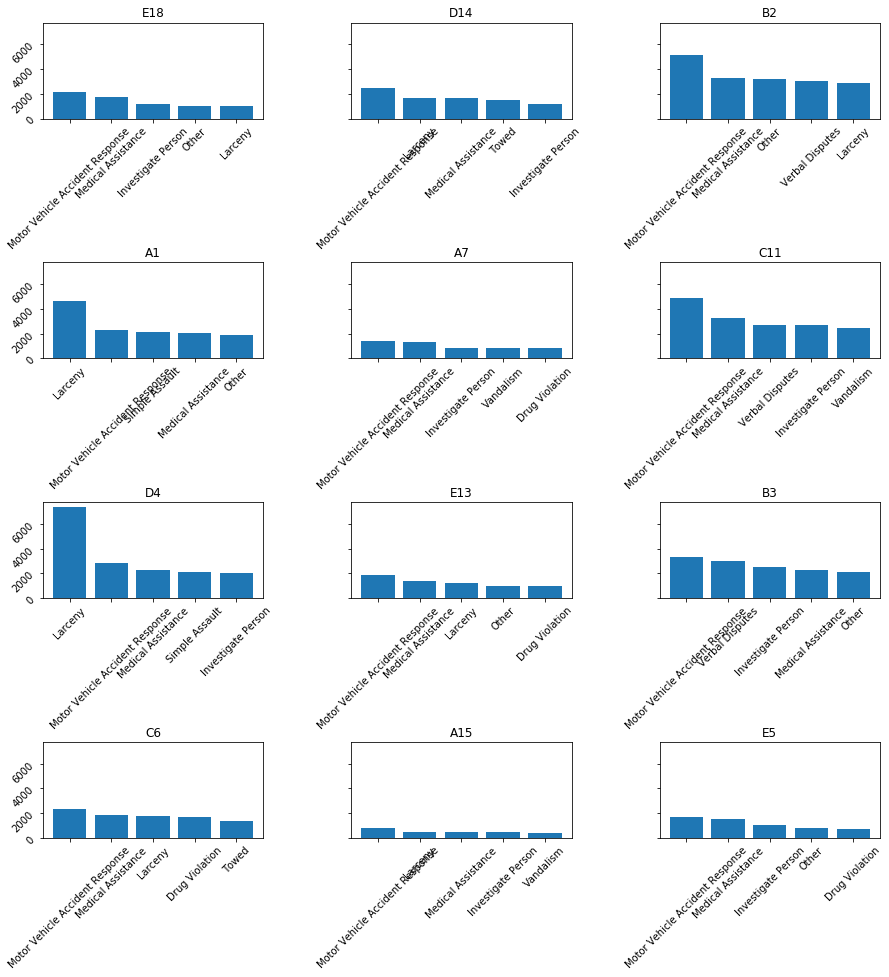

In [16]:
dist_unique = df['DISTRICT'].dropna().unique()
dist_unique = dist_unique.reshape(4, 3)

fig, ax = plt.subplots(4, 3, figsize=(15,15), sharey=True)
fig.subplots_adjust(hspace=1.5, wspace=0.4)

for i in range(4):
    for j in range(3):
        ax[i, j].bar(df[df['DISTRICT'] == dist_unique[i, j]]['OFFENSE_CODE_GROUP'].value_counts()[:5].index,
                     df[df['DISTRICT'] == dist_unique[i, j]]['OFFENSE_CODE_GROUP'].value_counts()[:5].values)
        ax[i, j].set_title(dist_unique[i, j])
        ax[i, j].tick_params(rotation=45)

x-tricks overlay but it is the most common five crimes for each district.

We can clearly say that the most common crime is motor vehicle for this city.

Text(0.5, 1.0, 'Distribution of Different Offenses')

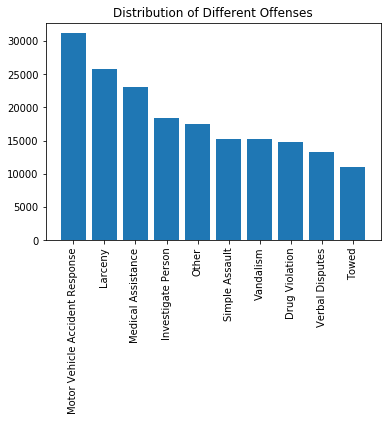

In [17]:
plt.bar(df['OFFENSE_CODE_GROUP'].value_counts().index[:10], df['OFFENSE_CODE_GROUP'].value_counts().values[:10])
plt.xticks(rotation='vertical')
plt.title('Distribution of Different Offenses')

## 4. What are the best locations for police stations?

It depends on how much police stations will be built and here is a clustering model for n police stations.

In [18]:
latlong = df[['Lat', 'Long', 'OFFENSE_CODE_GROUP']].dropna()
codegroup = df['OFFENSE_CODE_GROUP'].unique()
codemap = dict(zip(codegroup, range(len(codegroup))))
latlong['CodeMap'] = latlong['OFFENSE_CODE_GROUP'].map(codemap)
latlong.dtypes

Lat                   float64
Long                  float64
OFFENSE_CODE_GROUP     object
CodeMap                 int64
dtype: object

In [19]:
latlong['OFFENSE_CODE_GROUP'].value_counts()

Motor Vehicle Accident Response    31177
Larceny                            25795
Medical Assistance                 23029
Investigate Person                 18368
Other                              17499
                                   ...  
Explosives                            24
Gambling                               8
Manslaughter                           7
Burglary - No Property Taken           2
Biological Threat                      2
Name: OFFENSE_CODE_GROUP, Length: 63, dtype: int64

This is basically the map of crimes I prepared.

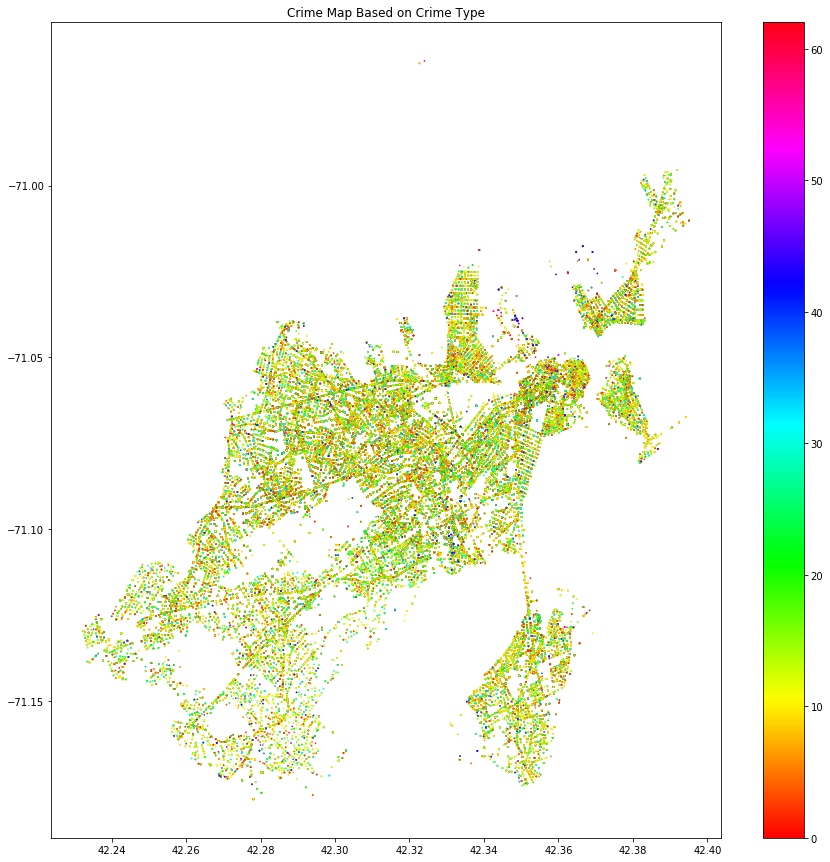

In [20]:
plt.figure(figsize=(15,15))
plt.scatter(latlong['Lat'], latlong['Long'], s=0.5, cmap='hsv', c=latlong['CodeMap'])
plt.title('Crime Map Based on Crime Type')
plt.colorbar()

In [21]:
codemap

{'Disorderly Conduct': 0,
 'Property Lost': 1,
 'Other': 2,
 'Aggravated Assault': 3,
 'Aircraft': 4,
 'Vandalism': 5,
 'Verbal Disputes': 6,
 'Simple Assault': 7,
 'Towed': 8,
 'Motor Vehicle Accident Response': 9,
 'Auto Theft': 10,
 'Medical Assistance': 11,
 'Investigate Person': 12,
 'Fire Related Reports': 13,
 'Larceny': 14,
 'Investigate Property': 15,
 'Harassment': 16,
 'Drug Violation': 17,
 'Violations': 18,
 'Liquor Violation': 19,
 'Fraud': 20,
 'Warrant Arrests': 21,
 'Recovered Stolen Property': 22,
 'Residential Burglary': 23,
 'Restraining Order Violations': 24,
 'Property Found': 25,
 'Missing Person Reported': 26,
 'Confidence Games': 27,
 'Ballistics': 28,
 'Larceny From Motor Vehicle': 29,
 'Landlord/Tenant Disputes': 30,
 'Firearm Violations': 31,
 'Missing Person Located': 32,
 'Prisoner Related Incidents': 33,
 'Robbery': 34,
 'Auto Theft Recovery': 35,
 'License Plate Related Incidents': 36,
 'Embezzlement': 37,
 'Property Related Damage': 38,
 'Other Burglary

In [22]:
from sklearn.cluster import KMeans

In [23]:
def find_n_station(n):
    model = KMeans(n_clusters=n)
    model.fit(latlong[['Lat', 'Long']])
    stations = model.cluster_centers_
    print('Best locations to build police stations:', stations)
    return model, stations

In [24]:
n = 5 # After I applied elbow method I decided to choose 5 as number of clusters
model, stations = find_n_station(n)
labels = model.predict(latlong[['Lat', 'Long']])


# Let's see where are our stations on map:

Best locations to build police stations: [[ 42.29766631 -71.07229905]
 [ 42.35054221 -71.14313019]
 [ 42.35746873 -71.05329568]
 [ 42.33152183 -71.08687888]
 [ 42.27240894 -71.12522238]]


Text(0.5, 1.0, 'Crime Map and 5 Possible Police Station Locations')

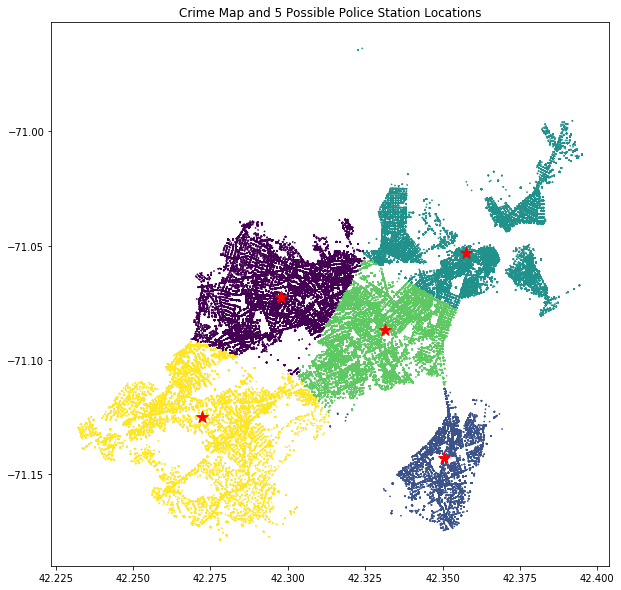

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(latlong['Lat'], latlong['Long'], c=labels, s=0.5, cmap='viridis')
plt.scatter(stations[:,0], stations[:,1], marker='*', s=150, c='r')
plt.title('Crime Map and {} Possible Police Station Locations'.format(n))

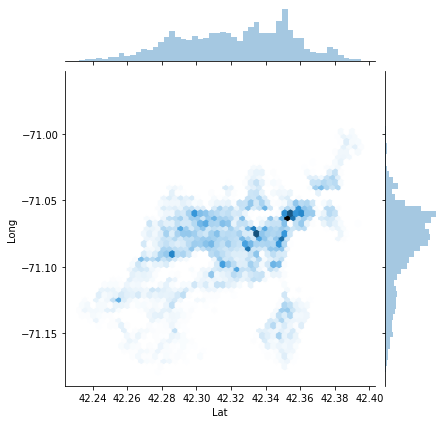

In [26]:
sns.jointplot(x="Lat", y="Long", data=latlong, kind='hex')

## 5. Is it possible to estimate the optimal size of the Boston police force?

In [27]:
district = df[df['Lat'] != -1][['Lat', 'Long', 'DISTRICT']].dropna()
district.head()

,Lat,Long,DISTRICT
0,42.262608,-71.121186,E18
1,42.352111,-71.135311,D14
2,42.308126,-71.076930,B2
3,42.359454,-71.059648,A1
4,42.375258,-71.024663,A7


In [28]:
distmap = dict(zip(district['DISTRICT'].unique(), range(len(district['DISTRICT'].unique()))))
district['DISTRICT'] = district['DISTRICT'].map(distmap)

Text(0.5, 1.0, 'Weighted District Map')

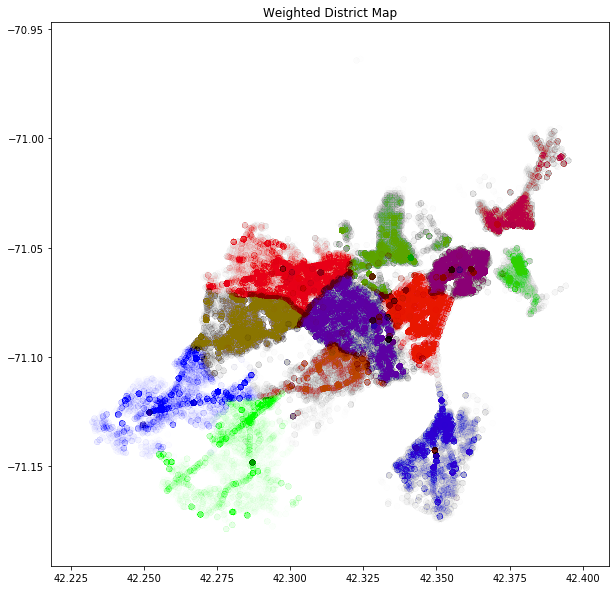

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(district['Lat'], district['Long'], c=district['DISTRICT'], cmap='brg', alpha=0.005)
plt.title('Weighted Crime Each District Map')

In [30]:
df.groupby('DISTRICT')['DISTRICT'].count().sort_values(ascending=False)

DISTRICT
B2     47291
C11    41956
D4     39533
B3     34578
A1     32699
C6     22445
D14    19584
E18    17067
E13    16921
A7     13078
E5     13059
A15     6292
Name: DISTRICT, dtype: int64

We can see the number of districts which offenses are committed. Darker colors mean that more offenses are committed there. For this reason, it can be said that the darker districts need more police forces. There are a lot of ways to analyse this such as by analysing the time or date. For instance, at nights, force cars would wait somewhere close to bars (I also thought it's a good feature to analyse but could not find any data about it).

## 6. How would you schedule and route the patrol cars?

In [31]:
schedule = df[['DAY_OF_WEEK', 'Night', 'Lat', 'Long']]

In [32]:
schedule['DAY_OF_WEEK'] = schedule['DAY_OF_WEEK'].map(day_of_week)

In [33]:
schedule

,DAY_OF_WEEK,Night,Lat,Long
0,3,1,42.262608,-71.121186
1,4,1,42.352111,-71.135311
2,3,1,42.308126,-71.076930
3,3,1,42.359454,-71.059648
4,3,1,42.375258,-71.024663
...,...,...,...,...
327815,7,0,42.336951,-71.085748
327816,4,0,42.255926,-71.123172
327817,4,0,42.255926,-71.123172
327818,2,1,42.302333,-71.111565


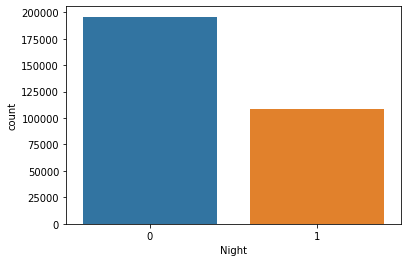

In [34]:
sns.countplot(x='Night', data=schedule)

In [35]:
schedule['Night'].value_counts()

0    195798
1    108705
Name: Night, dtype: int64

Night crimes for each day of week

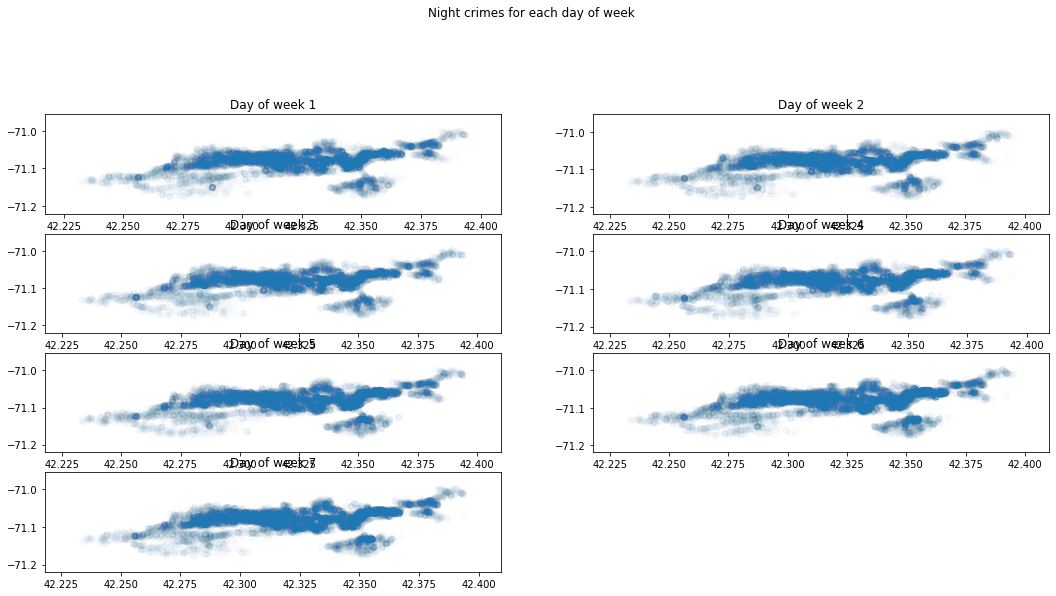

In [36]:
fig = plt.figure(figsize=(18,15))
fig.suptitle('Night crimes for each day of week')
for i in range(1,8):
    p = schedule[(schedule['DAY_OF_WEEK']==i) & (schedule['Night']==1)]
    ax = fig.add_subplot(7,2,i)
    ax.set_title('Day of week {}'.format(i))
    ax.scatter(p['Lat'], p['Long'], alpha=0.01)

Daytime crimes for each day of week

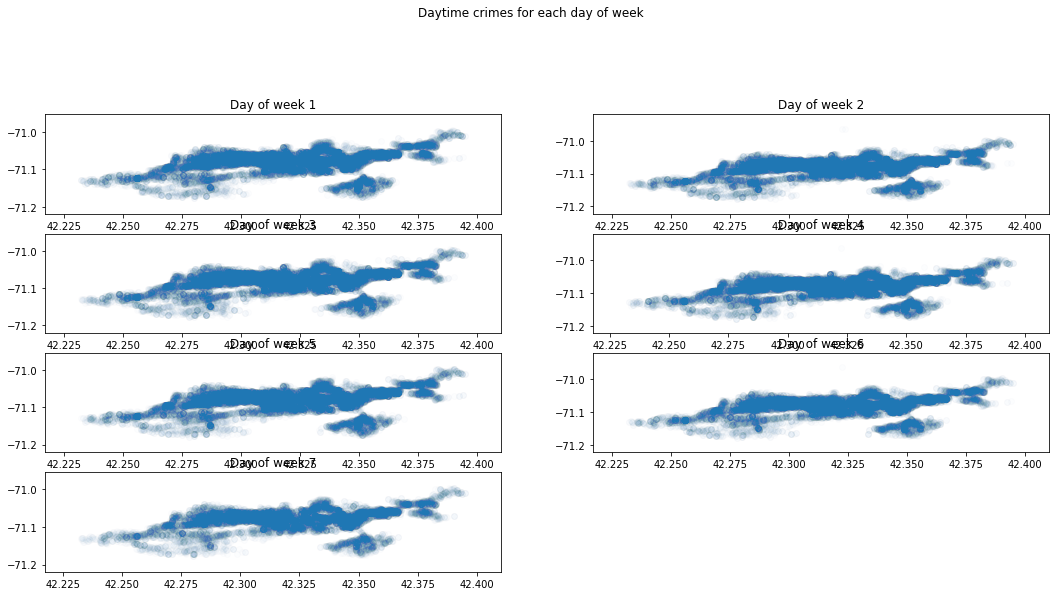

In [37]:
fig = plt.figure(figsize=(18,15))
fig.suptitle('Daytime crimes for each day of week')
for i in range(1,8):
    p = schedule[(schedule['DAY_OF_WEEK']==i) & (schedule['Night']==0)]
    ax = fig.add_subplot(7,2,i)
    ax.set_title('Day of week {}'.format(i))
    ax.scatter(p['Lat'], p['Long'], alpha=0.01)

I am not sure about question 5 and 6, wanted to solve it more clearly and there might have been better methtods but I do not know about them. Nevertheless, we have acquired data of patrol routes and schedules we can utilize. The analysis could have been more detailed.
Hope you like it.

There is a straight and strong line at both nights and on days, this line might be a good route for patrol cars. It is evident that there are more crimes committed on Mondays, Wednesdays and Fridays' night.


q5-6 içime sinmedi. Daha iyi çözmek istedim fakat daha iyi bir yöntem ne yazık ki bilmiyorum. Buna rağmen elimizde rotalar ve schedule için güzel veriler oluştu, analiz daha da ayrıntılandırılabilirdi. 

Hope you like it.

## References

[1] McClendon, Meghanathan. Using Machine Learning Algorithms to analyze Crime Data. Jackson; 2015
 
[2] Sathyadevan, S., S., Crime Analysis and Prediction Using Data Mining. Kerala; 2014